In [1]:
print("hello")

hello


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from mpl_toolkits import mplot3d
from numpy.random import uniform


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParamsDefault

import keras
from keras import initializers
import keras.layers as layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Dropout 
from keras.layers import LeakyReLU, Flatten, AveragePooling2D, BatchNormalization
from keras import backend as K
from keras.datasets import mnist

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.image import grayscale_to_rgb
from tensorflow import expand_dims


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
import time

from keras import backend as K


# Problem 1.1
Source: https://ruder.io/optimizing-gradient-descent/



#optimizers = ['Adagrad','RMSprop', 'Adadelta', 'Adam']
Constant learning rate for all features can cause problems because some features might be changing more than other features.
We adpat the learning rate for features so that the decay correspond to the update frequency.<br />

Let learning rate = $\eta$ <br />
Gadient at t = $g_t$ <br />
$\theta_{t+1} = \theta_{t} - \eta* g_t$ <br />

When we have d features with d weights.
For each weight i of d, we calculate the gradient at t for each i, giving us $g_{t,i}$, so weight update looks like:


$\theta_{t+1,i} = \theta_{t,i} - \eta \cdot g_{t,i}$ <br />



## Adagrad
Adagrad keeps running sum of the squared gradients for each dimension/feature.

Adagrad takes the square root of this squared gradient. It adds a small epsilon term so that the denominator is not zero, typically 
epsilon=1e-07 <br />

Let:<br />
$G_{t,ii}$ = Sum of Squared Gadient at t for weight i  <br />
$G_{t,ii}$ is a diagonal matrix with dimension $d xd$, where i,i element is the sum of squares of the gradient with respect to $\theta_i$ at time t. 

$g_{t,i} $ = calculate_gradient() <br />
$G_{t,ii} = G_{t-1,ii} + g_{t,i} * g_{t,i}$ <br />
$\theta_{t+1,i} = \theta_{t,i}  - \frac{\eta}{\sqrt {G_{t,ii} + \epsilon}}\cdot g_{t,i}$ <br />

The adgrad learning rate decays by factor of sum of past gradients.
When we have a gradient that's changing by a lot, the $G_t$ term is a large number. Dividing by large number means we slow down in that dimension.

But over the course of training, as t gets larger and larger, since it's accumulating all the past squared gradient sums, the steps get smaller and smaller over time. 

## RMSprop
RMSprop modifies Adagrad to address the problem of accumulated squared gradient that may slow down too much. <br />
It decays the squared gradient term using decay rate of rho: $\rho$, which is usually 0.9.

$g_t$ = calculate_gradient() <br />
grad_squared = $\rho$*grad_squared +  (1- $\rho$) $g_t$ * $g_t$ <br />
$w_{t+1}- w_{t} = - \frac{\eta}{\sqrt {grad_squared + \epsilon}}* g_t$ <br />

## RMSprop+Nesterov
RMSprop+Nesterov
RMSprop with nesterov momentum

## Adam
Adam updates the RMSProp, it's RMSprop with momentum.
Adam keeps exponentially decaying average of both the past squared gradients $v_t$ and gradients $m_t$ 

$m_t = \beta _{1} m_{t-1} + (1 - \beta _{1}) g_t$ <br />
$v_t = \beta _{2} v_{t-1} + (1 - \beta _{2}) g_t^2$<br /><br />

$m_t$ end up being estimate of the first moment, aka the mean of the gradient. <br />
And $v_t$ ennd up being estimate of the second moment, aka uncentered variance of the gradient. <br />

The $v_t$ and $m_t$ bias toward 0, so bias-corrected estimates are :

$\hat{m_t} = \frac{m_t}{1 - \beta _{1}^t}$

$\hat{v_t} = \frac{v_t}{1 - \beta _{2}^t}$

$\theta_{t+1} = \theta_{t}  - \frac{\eta}{\sqrt {\hat{v_t}} + \epsilon} \hat{m_t}$ <br />

## Adadelta
Adadelta also modifies Adagrad to address the problem of the learning rate decreasing so much that it's barely taking a step.
Instead of summing all past gradients, it only looks at a certain window of gradients and accumulates in that window w. But storing w previous gradients would be memory intensive, so this is handled by looking at the running average at time step t. The running average depends on previous time step's average. 

$E[g_t^2]_t = \gamma E[g_t^2]_{t_1} + ( 1- \gamma)* g_t^2$<br />
$\theta_{t+1,i} = \theta_{t,i}  - \frac{\eta}{\sqrt {E[g_t^2]_t + \epsilon}}\cdot g_{t,i}$ <br />

In [57]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)
print(x_train.shape,x_test.shape,y_train.shape, y_test.shape )

(50000, 32, 32, 3) (10000, 32, 32, 3) (50000, 1) (10000, 1)


In [58]:
x_train = x_train /255.0
x_test = x_test /255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

We will use multi-layer neural network model with two fully connected hidden layers with 1000 hidden units each and ReLU activation with minibatch size of 128.

In [59]:
def build_l2model():
    
    model = Sequential()
    model.add(Flatten(input_shape = (32,32,3)))
    model.add(Dense(1000, activation='relu',
                kernel_regularizer='l2',
                kernel_initializer= 'HeNormal'))
    model.add(Dense(1000,  activation='relu',
                kernel_regularizer='l2',
                kernel_initializer= 'HeNormal'))
    model.add(Dense(num_classes, activation='softmax',kernel_regularizer='l2',
                kernel_initializer= 'HeNormal'))
    return model 

def build_dropoutmodel():
    model = Sequential()
    model.add(Flatten(input_shape = (32,32,3)))
    model.add(Dropout(0.2))
    model.add(Dense(1000,  activation='relu',
                    kernel_regularizer='l2',
                    kernel_initializer= 'HeNormal',
                      bias_initializer= 'zeros'))
    model.add(Dropout(0.5))
    model.add(Dense(1000,  activation='relu',
                    kernel_regularizer='l2',
                    kernel_initializer= 'HeNormal',
                      bias_initializer= 'zeros'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [60]:
#set up all the optimizers- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop
#optimizers = ['Adagrad','RMSprop', 'NesRMSprop', 'Adadelta', 'Adam']
optimizers = ['Adagrad','RMSprop', 'Adadelta', 'Adam', 'Nadam']

#Adagrad
tf.keras.optimizers.Adagrad(
learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07,
name='Adagrad')

#RMSProp
tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name='RMSprop')


#RMSProp+ Nesterov
tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
    name='Nadam'
)


#Adadelta
tf.keras.optimizers.Adadelta(
    learning_rate=0.001, rho=0.95, epsilon=1e-07, name='Adadelta'
)

#Adam
tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

In [61]:
rows = []
test_result = []
epoch = 200

#build model
model = build_l2model()
print(model.summary())

#compile model 
for opt in optimizers:
    start = time.time()
    model.compile(optimizer= opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epoch, batch_size = 128,  verbose= 2)
    end = time.time()
    train_time = end - start 
    #record training_loss
    for i in range(epoch):
        rows.append([opt, 'l2', i, history.history['loss'][i]])

    #determine test accuracy
    test_loss, test_acc = model.evaluate(x_test, y_test,  batch_size = 128, verbose = 0)
    test_result.append([opt, 'l2', test_loss, test_acc, train_time])


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 1000)              3073000   
_________________________________________________________________
dense_42 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_43 (Dense)             (None, 10)                10010     
Total params: 4,084,010
Trainable params: 4,084,010
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
391/391 - 2s - loss: 41.2940 - accuracy: 0.2810
Epoch 2/200
391/391 - 2s - loss: 39.2631 - accuracy: 0.3518
Epoch 3/200
391/391 - 2s - loss: 37.4384 - accuracy: 0.3731
Epoch 4/200
391/391 - 2s - loss: 35.7295 - accuracy: 0.3

In [62]:
df = pd.DataFrame(rows, columns = ['optimizer', 'regularizer', 'epoch', 'train_loss'])
print(df)

    optimizer regularizer  epoch  train_loss
0     Adagrad          l2      0   41.294025
1     Adagrad          l2      1   39.263149
2     Adagrad          l2      2   37.438351
3     Adagrad          l2      3   35.729527
4     Adagrad          l2      4   34.119072
..        ...         ...    ...         ...
995     Nadam          l2    195    1.901350
996     Nadam          l2    196    1.900949
997     Nadam          l2    197    1.900271
998     Nadam          l2    198    1.900642
999     Nadam          l2    199    1.901211

[1000 rows x 4 columns]


In [65]:
test_result

[['Adagrad', 'l2', 1.8765023946762085, 0.4683000147342682, 443.3111345767975],
 ['RMSprop', 'l2', 2.0303874015808105, 0.3239000141620636, 530.2822144031525],
 ['Adadelta', 'l2', 1.897221326828003, 0.3752000033855438, 443.3992247581482],
 ['Adam', 'l2', 1.9111177921295166, 0.37279999256134033, 443.3963072299957],
 ['Nadam', 'l2', 1.8919519186019897, 0.3792000114917755, 804.2167756557465]]

# Problem 1.2

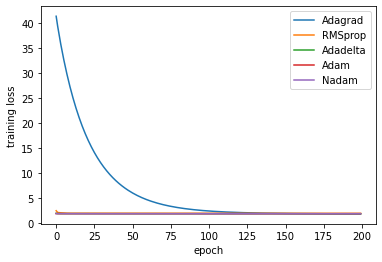

In [64]:
optimizers = ['Adagrad','RMSprop', 'Adadelta', 'Adam', 'Nadam']
for opt in optimizers:
    x = df[(df['optimizer'] == opt) & (df['regularizer'] == 'l2')]['epoch']
    y = df[(df['optimizer'] == opt) & (df['regularizer'] == 'l2')]['train_loss']
    plt.plot(x,y, label = opt)
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.legend()
plt.show()

# Problem 1.3 With Dropout

In [66]:
rows_d = []
test_result_d = []
epoch = 200

#build model
model = build_dropoutmodel()
print(model.summary())

#compile model 
for opt in optimizers:
    start = time.time()
    model.compile(optimizer= opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epoch, batch_size = 128,  verbose= 2)
    
    end = time.time()
    
    train_time = end - start 
    
    #record training_loss
    for i in range(epoch):
        rows_d.append([opt, 'dropout', i, history.history['loss'][i]])

    #determine test accuracy and record train_time
    test_loss, test_acc = model.evaluate(x_test, y_test,  batch_size = 128, verbose = 0)
    test_result_d.append([opt, 'dropout', test_loss, test_acc, train_time])


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 3072)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 1000)              3073000   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 10)              

In [53]:
df_d = pd.DataFrame(rows_d, columns = ['optimizer', 'regularizer', 'epoch', 'train_loss'])
print(df_d)

    optimizer regularizer  epoch  train_loss
0     Adagrad     dropout      0   41.426350
1     Adagrad     dropout      1   39.331089
2     Adagrad     dropout      2   37.506519
3     Adagrad     dropout      3   35.800369
4     Adagrad     dropout      4   34.190258
..        ...         ...    ...         ...
995     Nadam     dropout    195    2.054580
996     Nadam     dropout    196    2.052037
997     Nadam     dropout    197    2.055330
998     Nadam     dropout    198    2.057884
999     Nadam     dropout    199    2.054817

[1000 rows x 4 columns]


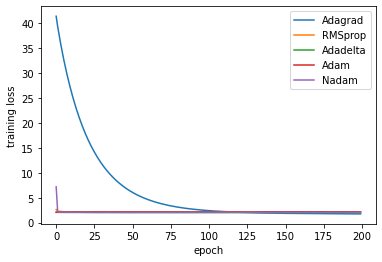

In [70]:
for opt in optimizers:
    x = df_d[(df_d['optimizer'] == opt) & (df_d['regularizer'] == 'dropout')]['epoch']
    y = df_d[(df_d['optimizer'] == opt) & (df_d['regularizer'] == 'dropout')]['train_loss']
    plt.plot(x,y, label = opt)
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.legend()
plt.show()

# Problem 1.4

In [68]:
test_result

[['Adagrad', 'l2', 1.8765023946762085, 0.4683000147342682, 443.3111345767975],
 ['RMSprop', 'l2', 2.0303874015808105, 0.3239000141620636, 530.2822144031525],
 ['Adadelta', 'l2', 1.897221326828003, 0.3752000033855438, 443.3992247581482],
 ['Adam', 'l2', 1.9111177921295166, 0.37279999256134033, 443.3963072299957],
 ['Nadam', 'l2', 1.8919519186019897, 0.3792000114917755, 804.2167756557465]]

In [69]:
test_result_d

[['Adagrad',
  'dropout',
  1.6932499408721924,
  0.48240000009536743,
  444.0087068080902],
 ['RMSprop',
  'dropout',
  2.0786454677581787,
  0.2903999984264374,
  563.633716583252],
 ['Adadelta',
  'dropout',
  1.9616326093673706,
  0.3305000066757202,
  503.4167637825012],
 ['Adam',
  'dropout',
  2.0967202186584473,
  0.2362000048160553,
  443.53918528556824],
 ['Nadam', 'dropout', 2.091763496398926, 0.210999995470047, 783.6976656913757]]

In [76]:
history.history['loss']

[2.1344244480133057,
 2.1309945583343506,
 2.127005100250244,
 2.1285126209259033,
 2.128910541534424,
 2.1249842643737793,
 2.124558687210083,
 2.126284599304199,
 2.1208229064941406,
 2.1214873790740967,
 2.132049798965454,
 2.140632390975952,
 2.1339070796966553,
 2.1244988441467285,
 2.1160244941711426,
 2.120306968688965,
 2.115420341491699,
 2.1146600246429443,
 2.114966630935669,
 2.114903211593628,
 2.117035150527954,
 2.1137819290161133,
 2.1133086681365967,
 2.112745523452759,
 2.1145851612091064,
 2.111621141433716,
 2.112164258956909,
 2.114119529724121,
 2.1126253604888916,
 2.119946241378784,
 2.111860513687134,
 2.1117119789123535,
 2.1108648777008057,
 2.113642692565918,
 2.111586332321167,
 2.11397123336792,
 2.113410711288452,
 2.112149238586426,
 2.1118252277374268,
 2.113434314727783,
 2.11379337310791,
 2.1093740463256836,
 2.1101572513580322,
 2.1133570671081543,
 2.111161947250366,
 2.1129138469696045,
 2.109222412109375,
 2.1145482063293457,
 2.11057710647583,
 

In [77]:
history.history['loss'][-1]

2.1105523109436035

# Problem 2

In [89]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [90]:
print(x_train.shape,x_test.shape,y_train.shape, y_test.shape )
num_classes= len(np.unique(y_test))
print('num of classes: %.f' %len(np.unique(y_test)))

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
num of classes: 10


Total dataset size: 70,000 <br />
Training size: 60,000 <br />
Testing size: 10,000 <br />
Number of classes: 10 <br />
Number of images per class:  <br />

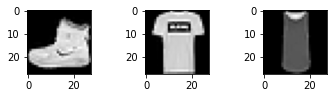

In [91]:
# plot first few images
for i in range(3):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

In [92]:
#pad each image with 0s to turn to 32*32 pixel images
x_train = np.pad(x_train, [(0,0), (0,4),(0,4)], 'constant')
x_test = np.pad(x_test, [(0,0), (0,4),(0,4)], 'constant')
print(x_train.shape)

#reshape to 4-dims so it works with Keras and convert to float to normalize
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1).astype('float32')

print(x_train.shape)
print(x_test.shape)

#divide by 255 to get pixel between 0 and 1
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

(60000, 32, 32)
(60000, 32, 32, 1)
(10000, 32, 32, 1)


In [93]:
print(x_train.shape,x_test.shape,y_train.shape, y_test.shape )

(60000, 32, 32, 1) (10000, 32, 32, 1) (60000, 10) (10000, 10)


In [94]:
def build_model():
    
    model = Sequential()
    model.add(Conv2D(filters=6, kernel_size=(3, 3), input_shape=(32,32,1), 
                     activation = 'relu'))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation = 'relu'))
    model.add(AveragePooling2D())

    #flattens output of final pooling layer for the fully connected layer
    model.add(Flatten())
    model.add(Dense(units=120, activation = 'relu'))


    model.add(Dense(units=84, activation = 'relu'))

    #output
    model.add(Dense(units=10, activation = 'softmax'))
    
    return model


In [128]:
MIN_LR = 1e-8
MAX_LR = 1e+2
BATCH_SIZE = 64
NUM_EPOCHS = 5
lr_vals = [1e-8* 10**i for i in range(10)]

In [133]:
lr_vals

[1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]

In [118]:
prob21= []
prob21.append([lr_val, train_loss])

In [134]:
prob2_2 = []
for lr_val in lr_vals:
    print('next learning rate--------')
    model = build_model()
    model.compile(loss="categorical_crossentropy", 
              optimizer=SGD(learning_rate = lr_val, momentum=0.9),
          metrics=["accuracy"])
    history = model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs= NUM_EPOCHS, 
                        verbose= 0)
    train_loss = history.history['loss'][-1]
    prob2_2.append([lr_val, train_loss])

next learning rate--------
next learning rate--------
next learning rate--------
next learning rate--------
next learning rate--------
next learning rate--------
next learning rate--------
next learning rate--------
next learning rate--------
next learning rate--------


In [138]:
df_2_2 = pd.DataFrame(prob2_2, columns = ['learning_rate', 'training_loss'])
print(df_2_2)

   learning_rate  training_loss
0   1.000000e-08       2.315298
1   1.000000e-07       2.294493
2   1.000000e-06       2.298950
3   1.000000e-05       2.286952
4   1.000000e-04       0.764375
5   1.000000e-03       0.508940
6   1.000000e-02       0.325579
7   1.000000e-01       0.354778
8   1.000000e+00       2.339034
9   1.000000e+01            NaN


In [150]:
import math
x = [math.log(val,10) for val in df_2_2['learning_rate']]

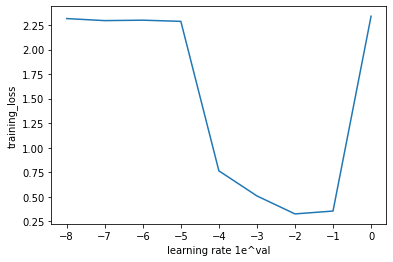

In [154]:
plt.plot(x, df_2_2['training_loss'])
plt.ylabel('training_loss')
plt.xlabel('learning rate 1e^val')
plt.show()

from the curve, we see that


lr_min = 1e-02
lr_max = 1e-05

# Problem 2_3

In [157]:
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [158]:
MIN_LR = 1e-05
MAX_LR = 1e-02
BATCH_SIZE = 64
STEP_SIZE = 8

In [159]:
model = build_model()
model.compile(loss="categorical_crossentropy", 
              optimizer=SGD(learning_rate = MIN_LR, momentum=0.9),
          metrics=["accuracy"])

In [162]:
clr = CyclicLR(mode = 'triangular',
               base_lr=MIN_LR,
               max_lr= MAX_LR,
               step_size= STEP_SIZE * x_train.shape[0] // BATCH_SIZE)

In [163]:
H = model.fit(x_train, y_train, batch_size = BATCH_SIZE,
             validation_data = (x_test, y_test), 
              steps_per_epoch = x_train.shape[0] //BATCH_SIZE,
              epochs = 96,
              callbacks = [clr],
              verbose = 2)

Epoch 1/96
937/937 - 6s - loss: 1.5996 - accuracy: 0.4184 - val_loss: 0.8159 - val_accuracy: 0.6754
Epoch 2/96
937/937 - 5s - loss: 0.6617 - accuracy: 0.7588 - val_loss: 0.5721 - val_accuracy: 0.7924
Epoch 3/96
937/937 - 5s - loss: 0.5493 - accuracy: 0.7980 - val_loss: 0.5200 - val_accuracy: 0.8136
Epoch 4/96
937/937 - 5s - loss: 0.4809 - accuracy: 0.8256 - val_loss: 0.4789 - val_accuracy: 0.8319
Epoch 5/96
937/937 - 5s - loss: 0.4355 - accuracy: 0.8407 - val_loss: 0.4483 - val_accuracy: 0.8366
Epoch 6/96
937/937 - 5s - loss: 0.4003 - accuracy: 0.8544 - val_loss: 0.4086 - val_accuracy: 0.8566
Epoch 7/96
937/937 - 5s - loss: 0.3693 - accuracy: 0.8648 - val_loss: 0.3858 - val_accuracy: 0.8608
Epoch 8/96
937/937 - 5s - loss: 0.3459 - accuracy: 0.8738 - val_loss: 0.3776 - val_accuracy: 0.8591
Epoch 9/96
937/937 - 5s - loss: 0.3177 - accuracy: 0.8822 - val_loss: 0.3434 - val_accuracy: 0.8760
Epoch 10/96
937/937 - 5s - loss: 0.2957 - accuracy: 0.8902 - val_loss: 0.3246 - val_accuracy: 0.8815

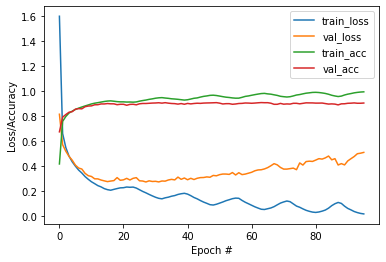

In [168]:
N = np.arange(0, 96)
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

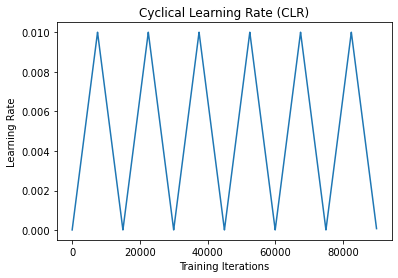

In [170]:
# plot the learning rate history
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
#of iteration in one epoch
x_train.shape[0] // BATCH_SIZE

In [182]:
#of iteration in one epoch * #of epochs
len(clr.history["lr"])

89952

In [181]:
clr.history["lr"][89951]

7.5268e-05

In [173]:
x_train.shape

(60000, 32, 32, 1)

In [174]:
STEP_SIZE * x_train.shape[0] // BATCH_SIZE

7500

In [177]:
x_train.shape[0] // BATCH_SIZE

937

# Problem 2d 

In [176]:
batch_sizes =  [64, 128, 256, 512, 1024, 2048, 4096, 8192]

# 

get the number of iterations using batch size of 64 and epoch of 5 & # of training data

n iter = n_train_size * 5 /batch_size


n_iter = 4685


for given_batch,calculate epoch


4685 = 60,000*epoch/given_batch

get training loss at the end

In [ ]:
prob2_4 = []
lr_val = 1e-05
NUM_EPOCHS = 5

for batch in batch_sizes:
    print('next learning rate--------')
    model = build_model()
    model.compile(loss="categorical_crossentropy", 
              optimizer=SGD(learning_rate = lr_val, momentum=0.9),
          metrics=["accuracy"])
    history = model.fit(x_train, y_train, batch_size = batch, 
                        verbose= 0)
    train_loss = history.history['loss'][-1]
    prob2_4.append([lr_val, train_loss])